In [1]:
import pandas as pd
import numpy as np
import simulations.gbm as sim
import matplotlib.pyplot as plt
import seaborn

seaborn.set()

Following dataset has entries for 4 nearest delivery months for WTI oil

In [2]:
raw_data = pd.read_excel("PET_PRI_FUT_S1_D.xls", sheet_name=1, header=2)
# also at https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls
raw_data.tail()

,Date,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
9288,2020-03-24,24.01,26.20,28.05,29.30
9289,2020-03-25,24.49,27.16,29.19,30.46
9290,2020-03-26,22.60,25.71,28.27,29.85
9291,2020-03-27,21.51,25.15,28.13,30.05
9292,2020-03-30,20.09,24.09,27.40,29.56


In [3]:
# set date as index for this time series
raw_data = raw_data.set_index("Date")

For nearest 1 month calendar spread, contract 1 and contract 2 has to be used. For May 2020, the option expiration is 20 April 2020 (day before the nearest of the two futures contracts expires), current calendar is available [here](https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_product_calendar_options.html?optionProductId=2952&optionExpiration=2952-K0#optionProductId=2952).  
The value of a calendar spread is for call (FC1-FC2-S)*1000 or 0 if it is negative. FC1 and FC2 are settlement prices when the option expires.

In [4]:
selected = raw_data.loc["2015-01-01":, raw_data.columns[0]:raw_data.columns[1]].copy()
selected.columns = ["Contract 1", "Contract 2"]
selected.tail()

,Contract 1,Contract 2
Date,,
2020-03-24,24.01,26.20
2020-03-25,24.49,27.16
2020-03-26,22.60,25.71
2020-03-27,21.51,25.15
2020-03-30,20.09,24.09


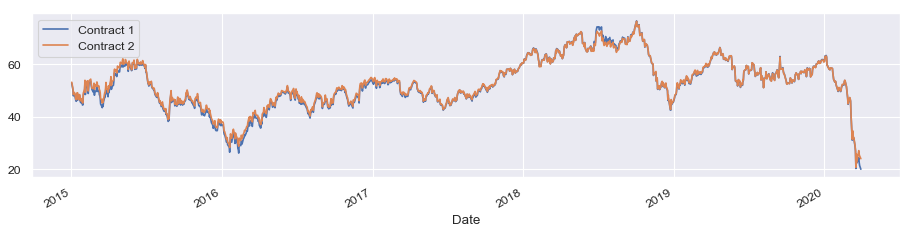

In [5]:
plt.figure(figsize=(14, 3), dpi= 80)
for col in selected.columns:
    selected[col].plot(legend=True)
plt.show()

In [6]:
logs = np.log(selected/selected.shift(1))
logs = logs.dropna()

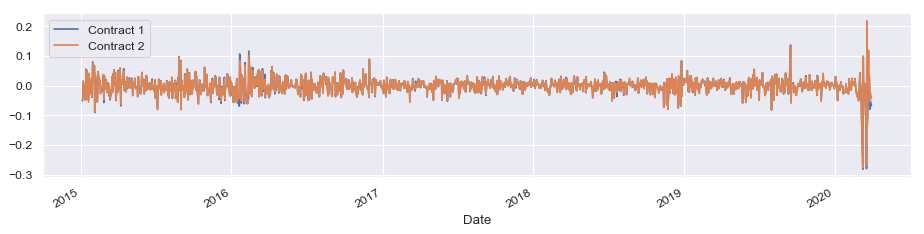

In [7]:
plt.figure(figsize=(14, 3), dpi= 80)
for col in logs.columns:
    logs[col].plot(legend=True)
plt.show()

When using two different products, it is necessary to include their correlation into simulation, so that the simulated prices move like in real life. Since both timeseries are futures on the same commodity and the only difference is their settlement date, the correlation is very close to 1. (following three lines of code show how to compute correlation in python using numpy)

In [8]:
corres1 = np.corrcoef(logs[logs.columns[0]],logs[logs.columns[1]])
cor1 = corres1[1,0]
cor1

0.9906418530514763

In [9]:
import scipy.stats as sps
from pandas.tseries.offsets import BDay
logs = logs.asfreq(BDay())
logs = logs.fillna(method='ffill').dropna()
logs

,Contract 1,Contract 2
Date,,
2015-01-05,-0.051603,-0.049996
2015-01-06,-0.043081,-0.041631
2015-01-07,0.014910,0.012713
2015-01-08,0.002874,0.004067
2015-01-09,-0.008852,-0.005902
...,...,...
2020-03-24,0.027445,0.027866
2020-03-25,0.019794,0.035986
2020-03-26,-0.080315,-0.054865


## Calendar spread simulation

Function simulates paths with a GBM model. Random noise is generated from normal distribution, the time gap is assumed to be 1 day, so delta t is 1.

In [10]:

from simulations.gbm import calendar_spread_gbm


### Estimate the discount rate

One part of an option's price is it's time value. After performing a simulation to estimate the option's final value, it is necessary to transform that value into a present one. That is done by discounting the value at expiration by a risk free rate. There are multiple possibilites from which risk free rate can be chosen:
 * Domestic risk free rates (Treasury bills, bonds or notes) [Risk free rates in wacc calculation](http://www.eru.cz/documents/10540/5475589/Navrh-zasad-cenove-regulace-2021-2025-pro-verejnou-konzultaci.pdf/f6df3fd5-d5af-425f-a53f-ecbddd4447fe)
 * Interest rates (LIBOR, PRIBOR)
 
Considering the Czech Republic, PRIBOR seems like the best best choice since it is regularly [updated](https://www.cnb.cz/en/financial-markets/money-market/pribor/fixing-of-interest-rates-on-interbank-deposits-pribor/) and offers several term options (1 month up to 1 year) to choose from, which is convenient for option pricing (unless it's an option that expires in a distant future, in that case bonds would be more suitable). [Emission of treasury bills](https://www.mfcr.cz/cs/verejny-sektor/rizeni-statniho-dluhu/emise-statnich-dluhopisu/emisni-kalendare-spp/2020/emisni-kalendar-statnich-pokladnicnich-p-37569) is less frequent with lower selection of due dates.  
<br>
In the following simulation, 1 month PRIBOR rate (1.04%) is used for `discount_rate`. Since the function expects year value, I will multiply the PRIBOR 1 month rate by 12, this is offseted by using 1/12 for the `maturity` parameter.

### Simulation

1 month calendar spread put option, strike is set to 0.1 dollars per barrel, maturity is in one month.

In [11]:
strike = 0.3 # in USD per barrel, arbitrarily chosen
discount_rate = 0.0104 * 12 # chosen discount rate
maturity = 1.0/12.0 # value of 1 means one year so 1/12th is one month
steps = 16
simulations = 500
position_flag = "p" # simulate for call option
history_size = 50

np.random.seed(19121995)

price, paths, step_range, params = calendar_spread_gbm(
    selected, # timeseries of futures price is inputted
    strike=strike,
    position_flag=position_flag,
    maturity=maturity,
    steps=steps,
    simulations=simulations,
    discount_rate=discount_rate,
    history_length=history_size,
    )

loc and std (1st asset) -0.021756444604341483 0.07349188883152369
loc and std (2nd asset) -0.018064827526514046 0.07487021625711777
corr coef: 0.9849428092045259


Price:  4.047910820646387
Contract unit price:  4047.910820646387


<Figure size 1120x240 with 0 Axes>

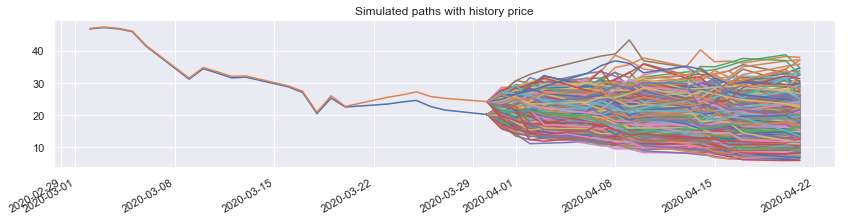

In [12]:
import matplotlib.dates as mdates
print("Price: ", price)
print("Contract unit price: ", price * 1000)
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
previous_part = selected.loc["2020-03-01":]
sim_dates = pd.bdate_range(start=selected.index[-1],periods=len(step_range))
start_d = previous_part.index[0]
end_d = sim_dates[-1]

fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.set_title("Simulated paths with history price")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.plot(previous_part)
for path in paths[0]:
    ax.plot(sim_dates, path)
for path in paths[1]:
    ax.plot(sim_dates, path)
fig.autofmt_xdate()
plt.show()

The contract is more closely described [here](https://www.cmegroup.com/content/dam/cmegroup/rulebook/NYMEX/3/397.pdf) and current info about price and volumes are [here](https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_contractSpecs_options.html?optionProductId=2952&optionExpiration=2952-K0#optionProductId=2952).

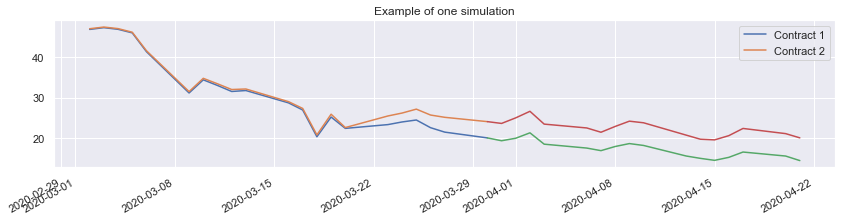

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.set_title("Example of one simulation")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

for col in previous_part.columns:
    ax.plot(previous_part[col], label=col)
ax.plot(sim_dates, paths[0][0])
ax.plot(sim_dates, paths[1][0])
fig.autofmt_xdate()
plt.legend()
plt.show()

### Compare result
This section contains calculations of option prices and comparisons with simulation result from previous part. For this purpose I will use Excel files that come with the book The Complete Guide to Option Pricing Formulas which contain functions that are ready for use to evaluate prices of vast variety of functions.  
<br>
The function I'm going to use accepts additional parameters, cost of carry for both assets (I will use value of 0) and quantity of both assets (I will use value of 1).

The values are now in a correct form to be inputted into the function.

In [14]:
params

,Params
S1,20.090000
S2,24.090000
X,0.300000
Maturity,0.083333
r,12.480000
sigma1,116.664757
sigma2,118.852784
cor,0.984943


Additional setup of the excel for this formula to be noted:  
 * Dropdown selection above the parameters input should be set to "years"
 * First dropdown selection that is to the right of the parameters input should be set to continuous

### Comparison result
The option price result from this function is 4,2557. The price I got from simulating 500 paths is 4.0479 (the number might be different because it is possible that I run the simulation again in the future and forget to change this text). Settled price for this option on CME was 4.31 for this day.  
<br>
Simulation yielded the lowest of the values. This suggests that the model is careful not to overprice the option. Since the simulated value of the option is less than the stock market's option price, if this model was to be trusted, it would not be advised to buy the option.  
<br>
Better model might give a result that is closer to the CME price. Different length of history interval from which I calculate volatility and correlation might give better (or worse) result.
<br>
Only 500 simulations were simulated, it is possible that by generating more paths, the price might move towards higher value.